In [193]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
import statsmodels as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [194]:
hdf = HDFStoreHelper("cfried.hd5")

In [239]:
pca_drop_std = hdf.get("pca_drop_std")
pheno = hdf.get("pheno")
pca_cov = hdf.get("pca_cov")
trait_complete = hdf.get("trait_complete")

In [350]:
trait_complete_pca = trait_complete.join(pca_cov, how="inner").merge(pca_drop_std, 
                                                left_index=True, 
                                                right_index=True,
                                               suffixes = ('_hierf','_pca'))

In [351]:
trait_name = str(dill.load(open("cfried_trait_name.dill")))

In [352]:
pca_cols = [x for x in trait_complete_pca if 'PC' in x]
pca_cols
pca_cov_string = "+".join(pca_cols)
pca_cov_string

'PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14'

In [353]:
p_fit = smf.ols(formula="%s~%s" % (trait_name, pca_cov_string), 
                data=trait_complete_pca).fit()

In [354]:
trait_complete_pca.columns = [x.replace("-", "_") if '_pca' in x else x for x in trait_complete_pca.columns]
trait_complete_pca.columns = ["X%s" % x if '_pca' in x else x for x in trait_complete_pca.columns]
trait_complete_pca.head()

,Longitude,Latitude,melezitose,county,state,lat,long,county_state,countyid,0-10037-01-257_hierf,0-10040-02-394_hierf,0-10044-01-392_hierf,0-10048-01-60_hierf,0-10051-02-166_hierf,0-10054-01-402_hierf,...,XUMN_CL299Contig1_01_46_pca,XUMN_CL306Contig1_04_261_pca,XUMN_CL307Contig1_04_143_pca,XUMN_CL319Contig1_03_131_pca,XUMN_CL326Contig1_05_421_pca,XUMN_CL339Contig1_05_39_pca,XUMN_CL34Contig1_03_89_pca,XUMN_CL353Contig1_04_64_pca,XUMN_CL362Contig1_07_133_pca,XUMN_CL363Contig1_01_233_pca,XUMN_CL379Contig1_12_117_pca,XUMN_CL424Contig1_03_94_pca,XUMN_CL54Contig1_07_88_pca,XUMN_CL91Contig1_02_246_pca,XUMN_CL97Contig_pca
8,-78.70453,34.33010,3.359321,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,-0.141186,0.000000,1.064324,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,1.229051,2.434228
12,-79.30539,33.36318,2.919807,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,...,-0.141186,-0.388627,1.064324,0.000000,1.034360,-0.225100,0.000000,-0.044142,0.570407,-0.277861,-0.064989,-0.779494,0.000000,-0.472712,0.000000
13,-77.05205,35.55349,3.048517,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,...,-0.141186,1.409903,-0.560743,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.570407,-0.277861,-0.064989,2.238546,-0.904873,1.229051,-0.679877
15,-77.06917,35.10917,2.527383,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,12,12,12,12,11,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,-0.225100,0.740705,-0.044142,0.570407,1.686782,-0.064989,-0.779494,0.567087,-0.472712,-0.679877
18,-77.05205,35.55349,3.048517,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,22,11,12,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,1.899281,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,-0.472712,-0.679877


In [355]:
hdf.put("trait_complete_pca", trait_complete_pca)

In [245]:
def get_locus_fit(df, locus, pca_cov_string):
    df[locus] = df[locus].astype(float)
    g_fit = smf.ols(formula="%s~%s" % (locus, pca_cov_string), data=df)
    return g_fit.fit()

snp_num = 0
snp_cor = {}
for col in trait_complete_pca:
    if "_pca" in col:
        formula="%s ~ %s" % (str(col), pca_cov_string)
        g_fit = smf.ols(formula=formula, data=trait_complete_pca).fit()
        corrected = pearsonr(g_fit.resid, p_fit.resid)
        snp_cor[col] = corrected
        snp_num += 1
        if snp_num % 100 == 0:
            print "at %d" % snp_num

at 100
at 200
at 300
at 400
at 500
at 600
at 700
at 800
at 900
at 1000
at 1100
at 1200
at 1300
at 1400
at 1500
at 1600
at 1700
at 1800
at 1900
at 2000
at 2100
at 2200
at 2300
at 2400
at 2500
at 2600
at 2700
at 2800
at 2900
at 3000


In [246]:
snp_cor_df = pd.DataFrame(snp_cor, index=("r", "p")).T

In [313]:
snp_cor_df.head()

,r,p,sig,q
X0_10037_01_257_pca,-0.042362,0.443099,False,0.964207
X0_10040_02_394_pca,-0.062683,0.256169,False,0.912507
X0_10044_01_392_pca,-0.018156,0.742457,False,0.977601
X0_10048_01_60_pca,-0.073602,0.182277,False,0.861624
X0_10051_02_166_pca,0.135985,0.013420,False,0.648732


In [314]:
q = multipletests(snp_cor_df.p, method="fdr_bh")

In [315]:
snp_cor_df['sig'] = q[0]
snp_cor_df['q'] = q[1]

In [316]:
len(snp_cor_df[snp_cor_df.p < 0.5])

1584

In [317]:
snp_cor_df[snp_cor_df.sig == True]

,r,p,sig,q
X0_16849_03_97_pca,-0.284650,0.000000,True,0.000443
XUMN_2809_01_235_pca,-0.271345,0.000001,True,0.000862


In [810]:
rc = Client(profile="gdcsrv2")
dview = rc[:]
lview = rc.load_balanced_view()
len(dview)

6

In [813]:
def do_pca_in_parallel(locus):
    import os,sys
    sys.path.append("/gdc_home4/cfried/ipython/")
    os.environ['R_HOME'] = '/gdc_home4/cfried/R3/lib64/R'
    import rpy2.robjects as ro
    import pandas.rpy.common as com
    from pandas import DataFrame
    from hdfstorehelper import HDFStoreHelper
    hdf = HDFStoreHelper("/gdc_home4/cfried/ipython/cfried.hd5")
    df = hdf.get("trait_complete_pca")
    r = ro.r
    prcomp = r('prcomp')
    df = df.ix[:,[x for x in df.columns if '_pca' in x]]
    df = df.drop(locus, axis=1)
    res = prcomp(com.convert_to_r_matrix(df), scale=False, center=False)
    x = com.convert_robj(res.rx2("x"))
    x.index = df.index
    return locus, x.ix[:,0:14].to_dict()

dview['do_pca_in_parallel'] = do_pca_in_parallel

pca_jobs = []
for col in trait_complete_pca:
    if "_pca" in col:
        job = lview.apply_async(do_pca_in_parallel, col)
        pca_jobs.append(job)

In [1031]:
ready = 0
pca_results = {}
for p in pca_jobs:
    if p.ready():
        res = p.r
        assert len(res) == 2
        pca_results[res[0]] = res[1]
        ready += 1
print ready, len(pca_jobs)

3082 3082


In [1040]:
trait_complete_pca.head()

,Longitude,Latitude,melezitose,county,state,lat,long,county_state,countyid,0-10037-01-257_hierf,0-10040-02-394_hierf,0-10044-01-392_hierf,0-10048-01-60_hierf,0-10051-02-166_hierf,0-10054-01-402_hierf,...,XUMN_CL299Contig1_01_46_pca,XUMN_CL306Contig1_04_261_pca,XUMN_CL307Contig1_04_143_pca,XUMN_CL319Contig1_03_131_pca,XUMN_CL326Contig1_05_421_pca,XUMN_CL339Contig1_05_39_pca,XUMN_CL34Contig1_03_89_pca,XUMN_CL353Contig1_04_64_pca,XUMN_CL362Contig1_07_133_pca,XUMN_CL363Contig1_01_233_pca,XUMN_CL379Contig1_12_117_pca,XUMN_CL424Contig1_03_94_pca,XUMN_CL54Contig1_07_88_pca,XUMN_CL91Contig1_02_246_pca,XUMN_CL97Contig_pca
8,-78.70453,34.33010,3.359321,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,-0.141186,0.000000,1.064324,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,1.229051,2.434228
12,-79.30539,33.36318,2.919807,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,...,-0.141186,-0.388627,1.064324,0.000000,1.034360,-0.225100,0.000000,-0.044142,0.570407,-0.277861,-0.064989,-0.779494,0.000000,-0.472712,0.000000
13,-77.05205,35.55349,3.048517,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,...,-0.141186,1.409903,-0.560743,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.570407,-0.277861,-0.064989,2.238546,-0.904873,1.229051,-0.679877
15,-77.06917,35.10917,2.527383,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,12,12,12,12,11,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,-0.225100,0.740705,-0.044142,0.570407,1.686782,-0.064989,-0.779494,0.567087,-0.472712,-0.679877
18,-77.05205,35.55349,3.048517,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,22,11,12,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,1.899281,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,-0.472712,-0.679877


In [1033]:
snp_num = 0
snp_cor2 = {}
for col in trait_complete_pca:
    if "_pca" in col:
        pca_cov2 = pd.DataFrame(pca_results[col])
        df = trait_complete_pca.merge(pca_cov2, how="inner", left_index=True,
                                     right_index=True, suffixes=('_x','_y'))
        pca_cov_string = "+".join(["%s_y" % x for x in pca_cov2.columns])
        formula="%s ~ %s" % (str(col), pca_cov_string)
        
        g_fit = smf.ols(formula=formula, data=df).fit()
        if snp_num % 100 == 0:
            print "at %d" % snp_num
        corrected = pearsonr(g_fit.resid, p_fit.resid)
        snp_cor2[col] = corrected
        snp_num += 1

at 0
at 100
at 200
at 300
at 400
at 500
at 600
at 700
at 800
at 900
at 1000
at 1100
at 1200
at 1300
at 1400
at 1500
at 1600
at 1700
at 1800
at 1900
at 2000
at 2100
at 2200
at 2300
at 2400
at 2500
at 2600
at 2700
at 2800
at 2900
at 3000


In [1034]:
snp_cor2_df = pd.DataFrame(snp_cor2, index=['r', 'p']).T

In [1039]:
snp_cor2_df

,r,p
X0_10037_01_257_pca,-0.036227,0.511938
X0_10040_02_394_pca,-0.055956,0.310855
X0_10044_01_392_pca,-0.032281,0.558995
X0_10048_01_60_pca,-0.079781,0.148150
X0_10051_02_166_pca,0.118151,0.031898
X0_10054_01_402_pca,-0.023837,0.666151
X0_10067_03_111_pca,0.007246,0.895673
X0_10079_02_168_pca,-0.066219,0.230266
X0_10112_01_169_pca,-0.017550,0.750766
X0_10113_01_119_pca,-0.003519,0.949226


In [1041]:
cors = snp_cor_df.merge(snp_cor2_df, how="inner", suffixes=['_1', '_2'], left_index=True, right_index=True)

In [1042]:
cors.head()

,r_1,p_1,sig,q,r_2,p_2
X0_10037_01_257_pca,-0.042362,0.443099,False,0.964207,-0.036227,0.511938
X0_10040_02_394_pca,-0.062683,0.256169,False,0.912507,-0.055956,0.310855
X0_10044_01_392_pca,-0.018156,0.742457,False,0.977601,-0.032281,0.558995
X0_10048_01_60_pca,-0.073602,0.182277,False,0.861624,-0.079781,0.148150
X0_10051_02_166_pca,0.135985,0.013420,False,0.648732,0.118151,0.031898


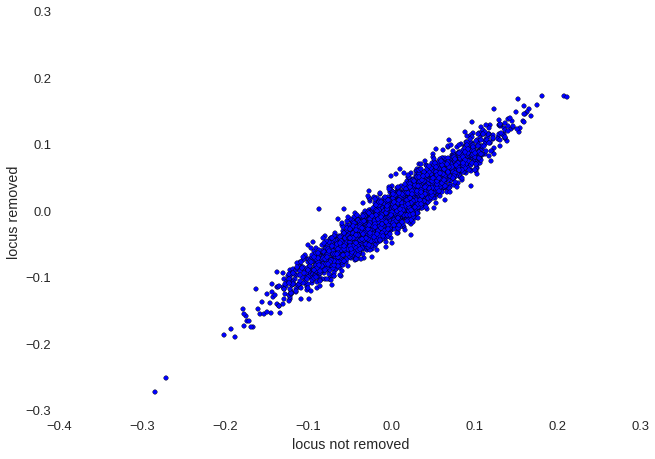

In [1043]:
plt.scatter(cors.r_1, cors.r_2)
plt.xlabel("locus not removed")
plt.ylabel("locus removed")
plt.show()

In [1045]:
hdf.put("snp_cor_df", snp_cor_df)
hdf.put("snp_cor2_df", snp_cor2_df)
hdf.put("cors", cors)

updating snp_cor_df
updating snp_cor2_df
